# Inferential Statistical Analysis of the Podcast 

## Objectives for this Part
- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice applying statistical inference procedures.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice creating dashboards with Google Data Studio.
- Practice reading data, performing queries and filtering data using SQL and Pandas.
- The dataset can be dowloaded: https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28

The aim of this paper is to provide suggestions on what features would be needed to make the podcast attractive to listeners and attract the largest possible target audience.
To achieve this goal, the podcast feedback database will be analysed and recommendations will be made on the basis of its answers. 
In addition, hypotheses will be put forward:

1. Hypothesis: is there any significant difference between podcasts groups ratings: single episodes vs. serial episodes?
2. Hypothesis: is there a difference between the length of the best rating feedback and the worst rating?

### Used Libraries:

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from collections import defaultdict
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from scipy import stats

print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

## Data Exploration

* Read sqlite query results into a pandas DataFrame:

In [3]:
con = sql.connect("database.sqlite")

<IPython.core.display.Javascript object>

* Extract tables from dataset:<br>
For analysis I will need categories, podcasts and reviews tables that are connected via 'podcast_id' column between themselves.
From here I will review all tables separately and where needed merge them between for further investigation.

In [4]:
query = pd.read_sql_query(
    """SELECT name AS table_name, sql AS table_scheme
FROM sqlite_master
ORDER BY name""",
    con,
)
pd.set_option("display.max_colwidth", None)
query

,table_name,table_scheme
0,categories,"CREATE TABLE categories (\n podcast_id text not null,\n category text not null\n )"
1,category_podcast_id_idx,CREATE INDEX category_podcast_id_idx on categories (podcast_id)
2,podcasts,"CREATE TABLE podcasts (\n podcast_id text primary key,\n itunes_id integer not null,\n slug text not null,\n itunes_url text not null,\n title text not null\n )"
3,reviews,"CREATE TABLE reviews (\n podcast_id text not null,\n title text not null,\n content text not null,\n rating integer not null,\n author_id text not null,\n created_at text not null\n , review_date DATETIME)"
4,runs,"CREATE TABLE runs (\n run_at text not null,\n max_rowid integer not null,\n reviews_added integer not null\n )"
5,sqlite_autoindex_podcasts_1,None


<IPython.core.display.Javascript object>

* Checking if there are any missing vallues in all tables:

In [5]:
query = pd.read_sql_query(
    """
SELECT 
    (SELECT COUNT(*) FROM categories WHERE podcast_id IS NULL OR category IS NULL) AS category_null_count,
    (SELECT COUNT(*) FROM podcasts WHERE podcast_id IS NULL OR title IS NULL) AS question_null_count,
    (SELECT COUNT(*) FROM reviews WHERE podcast_id IS NULL OR content IS NULL OR rating IS NULL OR author_id IS NULL OR
                                       review_date IS NULL) AS answer_null_count""",
    con,
)
query


,category_null_count,question_null_count,answer_null_count
0,0,0,2


<IPython.core.display.Javascript object>

In [6]:
df_reviews_null = pd.DataFrame(
    pd.read_sql_query(
        """SELECT podcast_id, content, rating, author_id,  review_date FROM reviews WHERE podcast_id IS NULL OR content IS NULL OR rating IS NULL OR author_id IS NULL OR
                                       review_date IS NULL""",
        con,
    )
)
df_reviews_null

,podcast_id,content,rating,author_id,review_date
0,db93a05fe337aea2061b59c96e647100,"Joe is my source for Honest, Hard Hitting Comedy ,Sports ,& Modern Culture in America",5,3BBAB440E06A8CB,None
1,db93a05fe337aea2061b59c96e647100,I only listened to 4 podcasts but they were enough to get me hooked. What do I have to do to regain access to the library?,5,3E66B9924F0D870,None


<IPython.core.display.Javascript object>

* **Summary**:<br>
    Overall there are no missing values except table reviews has 2 missing values in 'review_date' column. This quantity is too small for interfering with our data, but the remaining information is usefull for further investigation.

* Investigating table "Podcasts":

In [7]:
df_podcast = pd.DataFrame(
    pd.read_sql_query(
        """SELECT podcast_id, title
       FROM podcasts

       """,
        con,
    )
)

df_podcast.head()

,podcast_id,title
0,a00018b54eb342567c94dacfb2a3e504,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,Word on the Street w/ Dreak Swift


<IPython.core.display.Javascript object>

In [9]:
df_podcast = df_podcast.drop(columns=[])
print("Total Podcast Quantity: ", df_podcast.shape[0])
print("***********************************")
print(
    "Pocast Quantity by Title (Top 10 values): \n",
    df_podcast.title.value_counts().head(10),
)

Total Podcast Quantity:  110024
***********************************
Pocast Quantity by Title (Top 10 values): 
 No Title              8
Guided Meditations    4
Welcome Home          4
Office Hours          4
What's Next?          4
Podcast               4
Unfiltered            4
Speak Your Mind       4
Catching Up           4
Digging Deep          3
Name: title, dtype: int64


<IPython.core.display.Javascript object>

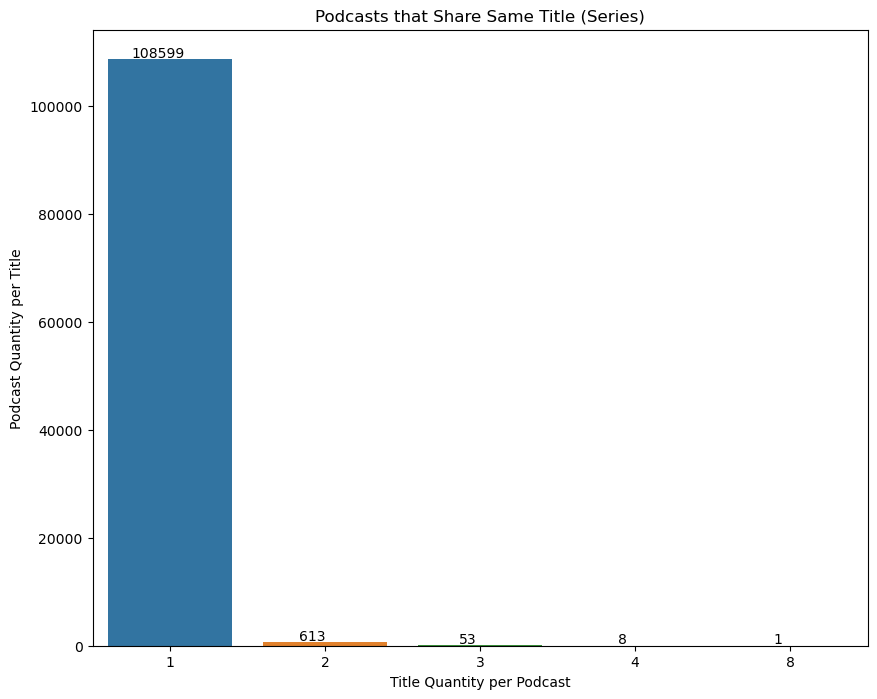

<IPython.core.display.Javascript object>

In [10]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x=df_podcast.title.value_counts(), data=df_podcast)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 6),
        textcoords="offset pixels",
    )
plt.xlabel("Title Quantity per Podcast")
plt.ylabel("Podcast Quantity per Title")
plt.title("Podcasts that Share Same Title (Series)")
plt.show()

In [11]:
df_podcast[df_podcast["title"] == "No Title"]

,podcast_id,title
5810,a51c5579ffb2a5c12ac46f945b2a6a96,No Title
10887,a9842ba7e08f3356749cf2f3a2a4392b,No Title
25730,b658da8ac2c0ace318d7604cfb958178,No Title
55077,cfe5765860da1c42f853767eb0ff5f4f,No Title
66992,da6287a693d31247dcaad76c5c117b1c,No Title
81511,e71818314eb04a512511c41bd124c91f,No Title
96861,f47728bb8acc39b317f4e4325a2ae700,No Title
105954,fc6fd07daed42b85310380566ba6b461,No Title


<IPython.core.display.Javascript object>

In [12]:
grouped = df_podcast.groupby("title")
single_titles = grouped.filter(lambda x: len(x) == 1 or x.name == "No Title")
series_titles = grouped.filter(lambda x: len(x) > 1 and x.name != "No Title")
single_titles.loc[single_titles["title"] == "No Title", "podcast_type"] = "single"
single_titles.loc[single_titles["title"] != "No Title", "podcast_type"] = "single"
series_titles["podcast_type"] = "series"
df_podcast = pd.concat([single_titles, series_titles])

<IPython.core.display.Javascript object>

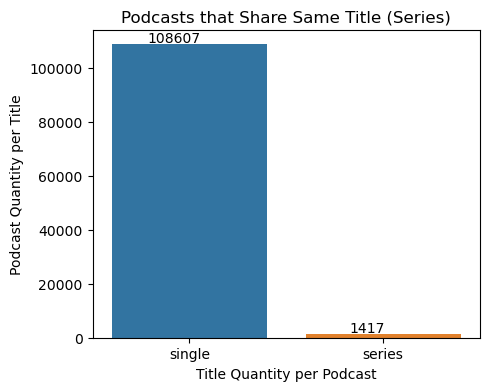

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(x=df_podcast.podcast_type, data=df_podcast)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 6),
        textcoords="offset pixels",
    )
plt.xlabel("Title Quantity per Podcast")
plt.ylabel("Podcast Quantity per Title")
plt.title("Podcasts that Share Same Title (Series)")
plt.show()

* **Summary**:<br>
    - Table in it's initial form contains 5 columns, but for our purpose we will use 2 columns: podcast_id and title.<br>
    - There are 110024 podcasts in this dataset. <br>
    - After counting the shows by their titles, we conclude that the repeating titles with different podcast_id are serial shows. <br>
    - It is noticeable that there are 8 podcasts without a title. We will classify them as separate shows.
    - Add an extra column podcast_type to distinguish between episodes (single_titles and serial_titles).

* Investigating table "Reviews":<br>
For investigation purposes we add podcast title to the review table.


In [13]:
df_reviews = pd.DataFrame(
    pd.read_sql_query(
        """SELECT p.podcast_id, p.title, r.content, r.rating, r.author_id, r.review_date
       FROM reviews AS r
       JOIN podcasts AS p ON p.podcast_id = r.podcast_id
       

       """,
        con,
    )
)

df_reviews.head()

,podcast_id,title,content,rating,author_id,review_date
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24 12:05:16
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09 18:14:32
2,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,"I'm a liberal myself, but its pretty obvious and annoying that they're trying to push their beliefs on the listeners. Get a more politically diverse production staff, we like to see issues from multiple point of views not just yours.",1,1AB95B8E6E1309E,2019-06-11 14:53:39
3,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,I find Tedx talks very inspirational but I often don’t have time to watch a video. I love that this provides an easy way for me to get in diverse information.,5,11BB760AA5DEBD1,2018-05-31 13:08:09
4,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19 13:56:05


<IPython.core.display.Javascript object>

In [14]:
df_reviews.shape

(2043297, 6)

<IPython.core.display.Javascript object>

In [15]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043297 entries, 0 to 2043296
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   podcast_id   object
 1   title        object
 2   content      object
 3   rating       int64 
 4   author_id    object
 5   review_date  object
dtypes: int64(1), object(5)
memory usage: 93.5+ MB


<IPython.core.display.Javascript object>

In [16]:
df_reviews.rating.describe().round(2)

count    2043297.00
mean           4.63
std            1.05
min            1.00
25%            5.00
50%            5.00
75%            5.00
max            5.00
Name: rating, dtype: float64

<IPython.core.display.Javascript object>

* **Note**:<br>
- In total there are 2043297 reviews.
-  We can see that the majority of the ratings fall at the high end of the scale, with 25%, 50%, and 75% of the ratings being 5.00. Additionally, the standard deviation of the ratings is relatively low, indicating that the ratings are clustered relatively close to the mean value.

* What is the distribution of feedback per year?:

In [17]:
df_reviews["review_date"] = pd.to_datetime(df_reviews["review_date"])
df_reviews["Year"] = df_reviews["review_date"].dt.to_period("Y")
df_reviews["Year"].value_counts().sort_index(ascending=True)
year_order = sorted(df_reviews["Year"].dropna().unique())

<IPython.core.display.Javascript object>

In [18]:
print("First review date in dataset: ", df_reviews["review_date"].min())
print("Last review date in dataset: ", df_reviews["review_date"].max())


First review date in dataset:  2005-12-09 21:41:01
Last review date in dataset:  2023-02-16 08:38:37


<IPython.core.display.Javascript object>

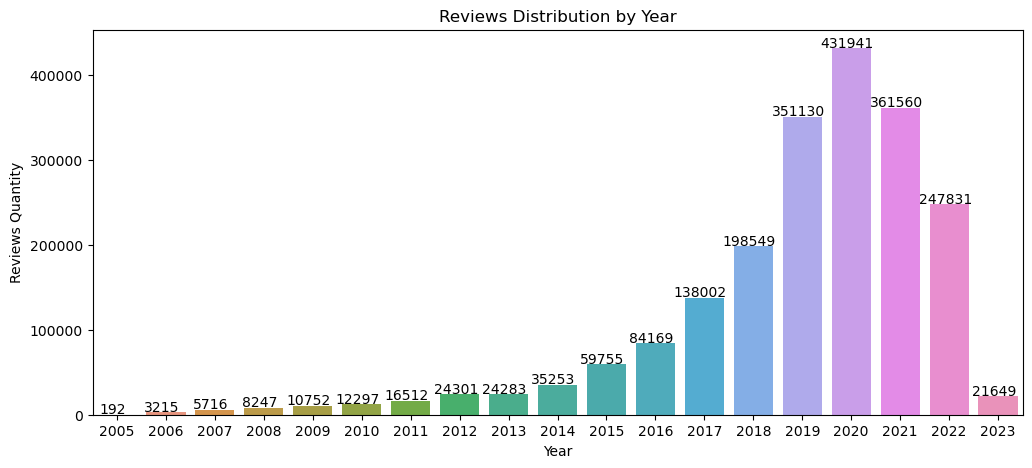

<IPython.core.display.Javascript object>

In [53]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=df_reviews, x="Year", order=year_order)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset pixels",
    )
plt.xlabel("Year")
plt.ylabel("Reviews Quantity")
plt.title("Reviews Distribution by Year")
plt.show()

* **Summary**: <br>
 - On our previous dataset investigation we had 2 entries without a date. Since this is crucial in this part we exclude them from our plot.
 - The increase in interest in the broadcasts and in the number of reviews can be attributed to the global crises. For example, the COVID-19 pandemic that began in 2019, which led to restrictions on movement, travel, business and other activities. As a result, a more sedentary lifestyle could also stimulate interest in the different types of podcasts presented.

* Let's see how many reviews a podcast would need to be one of the most popular:

In [19]:
reviews_count = df_reviews.groupby("podcast_id")["content"].count()
quantiles = {
    "50%": int(np.quantile(reviews_count, 0.5)),
    "75%": int(np.quantile(reviews_count, 0.75)),
    "90%": int(np.quantile(reviews_count, 0.9)),
    "95%": int(np.quantile(reviews_count, 0.95)),
    "99%": int(np.quantile(reviews_count, 0.99)),
}

for k, v in quantiles.items():
    percent = v * 100 / len(reviews_count)
    print(
        f"If you have {v} or more reviews, you have more reviews than {percent:.3f}% of all shows"
    )
reviews_count.sum()

If you have 3 or more reviews, you have more reviews than 0.003% of all shows
If you have 8 or more reviews, you have more reviews than 0.007% of all shows
If you have 26 or more reviews, you have more reviews than 0.024% of all shows
If you have 58 or more reviews, you have more reviews than 0.053% of all shows
If you have 317 or more reviews, you have more reviews than 0.288% of all shows


2043297

<IPython.core.display.Javascript object>

* **Note**:
Given that total quantity of reviews of all dataset is 2043297, the 0.288% percent is 5,885 of podcasts.

* So, lets check how podcast reviews are distributed in more visual grouping:

In [20]:
df_review_counts = (
    df_reviews.groupby("podcast_id").size().reset_index(name="reviews_count")
)
total_podcasts = df_review_counts["podcast_id"].nunique()
bins = [0, 2, 7, 25, 57, 316, max(df_review_counts["reviews_count"])]
labels = [
    "1-2 reviews",
    "3-7 reviews",
    "8-25 reviews",
    "26-57 reviews",
    "58-316 reviews",
    "317+ reviews",
]

df_review_counts["review_group"] = pd.cut(
    df_review_counts["reviews_count"], bins=bins, labels=labels
)
grouped = df_review_counts.groupby("review_group")["podcast_id"].count()
grouped

review_group
1-2 reviews       53231
3-7 reviews       28606
8-25 reviews      17096
26-57 reviews      5562
58-316 reviews     4426
317+ reviews       1103
Name: podcast_id, dtype: int64

<IPython.core.display.Javascript object>

* Plot the percentage distribution of reviews in each group:

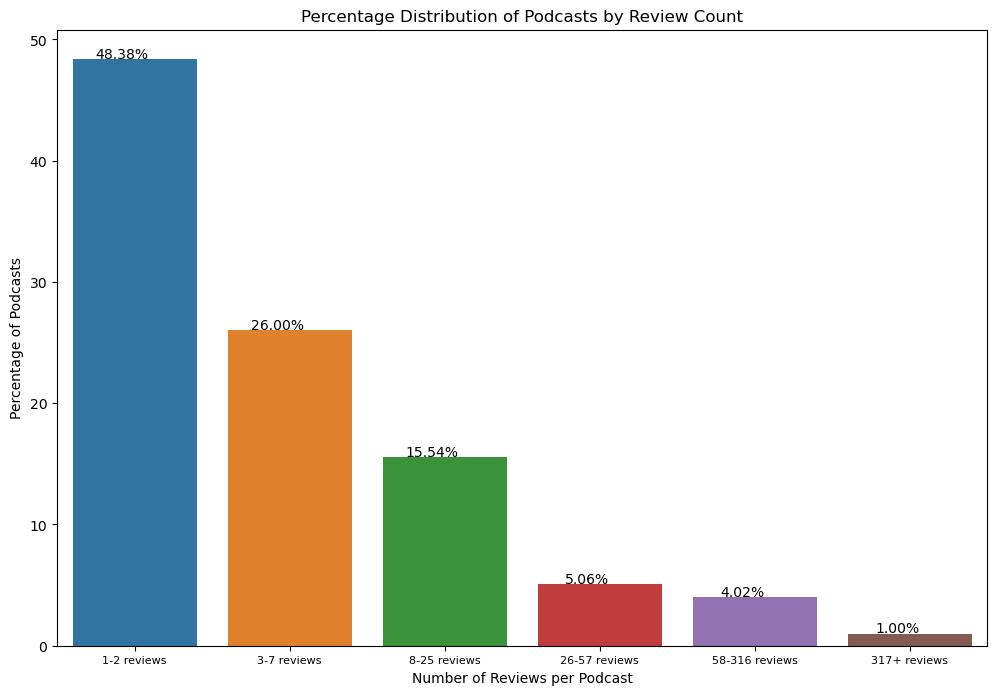

<IPython.core.display.Javascript object>

In [21]:
podcasts_proportions = grouped / total_podcasts * 100

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=podcasts_proportions.index, y=podcasts_proportions)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.2f}%",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset pixels",
    )
plt.xticks(fontsize=8, rotation=0)
plt.xlabel('Number of Reviews per Podcast')
plt.ylabel('Percentage of Podcasts')
plt.title('Percentage Distribution of Podcasts by Review Count')
plt.show()


* Checking reviews distribution based on podcast_type

In [22]:
df_reviews = (
    pd.merge(df_reviews, df_podcast, how="inner", on="podcast_id")
    .rename(columns={"title_x": "title"})
    .drop(columns="title_y")
)
df_reviews.head()

,podcast_id,title,content,rating,author_id,review_date,Year,podcast_type
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24 12:05:16,2018,single
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09 18:14:32,2018,single
2,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,"I'm a liberal myself, but its pretty obvious and annoying that they're trying to push their beliefs on the listeners. Get a more politically diverse production staff, we like to see issues from multiple point of views not just yours.",1,1AB95B8E6E1309E,2019-06-11 14:53:39,2019,single
3,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,I find Tedx talks very inspirational but I often don’t have time to watch a video. I love that this provides an easy way for me to get in diverse information.,5,11BB760AA5DEBD1,2018-05-31 13:08:09,2018,single
4,ad4f2bf69c72b8db75978423c25f379e,TED Talks Daily,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19 13:56:05,2019,single


<IPython.core.display.Javascript object>

* **Note**:<br>
    How statistically significant the rating mean among podcast types? By using a t-test, we can avoid data issues such as making assumptions about the normal distribution of the data.

In [24]:
# Separate dataframes for Single and Series podcasts
df_single = df_reviews[df_reviews["podcast_type"] == "single"]
df_series = df_reviews[df_reviews["podcast_type"] == "series"]
alpha = 0.05
# Calculate the t-test
t, p = stats.ttest_ind(df_single["rating"], df_series["rating"], equal_var=False)
if p < alpha:
    print("The mean difference is statistically significant.")
else:
    print("The mean difference is not statistically significant.")
print("t-value:", t)
print("p-value:", p)

The mean difference is statistically significant.
t-value: 16.25475896170665
p-value: 3.745498969078223e-59


<IPython.core.display.Javascript object>

* Conclusion:<br>
The probability of observing a difference in means as extreme as the one calculated, assuming that the means are actually equal, is extremely low. Therefore, with 95% confidence we can reject the null hypothesis and conclude that the mean rating for single podcasts is statistically significantly different from the mean rating for series podcasts. <br> - The t-value is used in hypothesis testing to determine whether the difference between two groups is statistically significant or not. A t-value greater than 2 or less than -2 is generally considered to be statistically significant, indicating that the difference between the two groups is unlikely to have occurred by chance.

* Checking the description of dataset ratings based on podcast types and get what is the diffrence between rating means:

In [25]:
single_podcast_ratings = df_reviews[df_reviews["podcast_type"] == "single"]["rating"]
series_podcast_ratings = df_reviews[df_reviews["podcast_type"] == "series"]["rating"]
pd.options.display.float_format = "{:.2f}".format
print("Single Podcasts:")
print(single_podcast_ratings.describe())

print("\nSeries Podcasts:")
print(series_podcast_ratings.describe())

mean_rating_difference = single_podcast_ratings.mean() - series_podcast_ratings.mean()
print("The diffrence of podcasts ratings mean: ", mean_rating_difference)

Single Podcasts:
count   2014561.00
mean          4.63
std           1.04
min           1.00
25%           5.00
50%           5.00
75%           5.00
max           5.00
Name: rating, dtype: float64

Series Podcasts:
count   28736.00
mean        4.52
std         1.16
min         1.00
25%         5.00
50%         5.00
75%         5.00
max         5.00
Name: rating, dtype: float64
The diffrence of podcasts ratings mean:  0.1120686713675898


<IPython.core.display.Javascript object>

* Conclusion:<br>
We can see that the majority of the ratings fall at the high end of the scale, with 25%, 50%, and 75% of the ratings being 5.00. Additionally, the standard deviation of the ratings is relatively low, indicating that the ratings are clustered relatively close to the mean value.<br>
The difference of podcasts mean shows, that single podcasts tend to get higher evaluations.

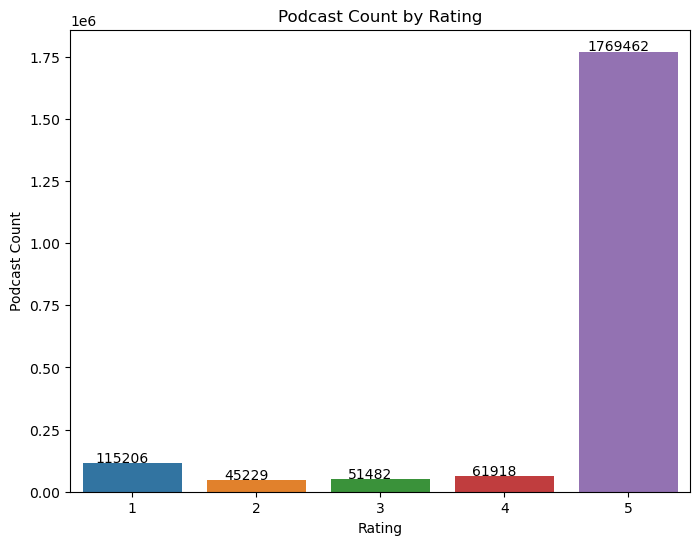

<IPython.core.display.Javascript object>

In [26]:
rating_counts = (
    df_reviews.groupby("rating")["podcast_id"]
    .count()
    .rename("podcast_count")
    .reset_index()
    .sort_values("podcast_count", ascending=False)
)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x="rating", y="podcast_count", data=rating_counts)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset pixels",
    )
ax.set_xlabel("Rating")
ax.set_ylabel("Podcast Count")
ax.set_title("Podcast Count by Rating")
plt.show()

* **Note**: <br>
As we observe he vast majority (86.60%) are 5-star ratings. The second choice was 1-star ratings. That is people either love podcast or hate it.

* Let's check the hypothesis that people tend to write longer reviews when they are disappointed or not happy about product (in our case podcast)

* Hypothesis: 
    - Null hypothesis (H0): review_1_length = review_5_length
    - Alternative hypothesis (HA): review_1_length != review_5_length

In [27]:
# Filtering only English based content
english_pattern = r"[A-Za-z0-9]"
df_reviews = df_reviews[
    df_reviews["content"].str.contains(english_pattern, regex=True, na=False)
]
df_reviews.content.count()

2035356

<IPython.core.display.Javascript object>

In [28]:
# Separate dataframes for Single and Series podcasts
df_5_star = df_reviews[df_reviews["rating"] == 5]
df_1_star = df_reviews[df_reviews["rating"] == 1]
review_5_length = df_5_star["content"].str.len()
review_1_length = df_1_star["content"].str.len()

<IPython.core.display.Javascript object>

In [29]:
t, p = stats.ttest_ind(review_1_length, review_5_length, equal_var=False)
alpha = 0.05
print("t-value:", t)
print("p-value:", p)
if p < alpha:
    print(
        "Reject null hypothesis: there is a significant difference between the mean length of 5-star reviews and 1-star reviews"
    )
else:
    print(
        "Fail to reject null hypothesis: there is no significant difference between the mean length of 5-star reviews and 1-star reviews"
    )

t-value: 57.345413249169574
p-value: 0.0
Reject null hypothesis: there is a significant difference between the mean length of 5-star reviews and 1-star reviews


<IPython.core.display.Javascript object>

* Conclusion:
The probability of observing a difference in means, assuming that the means are actually equal, is extremely low. Therefore, we can reject the null hypothesis and conclude that the mean length for 5-star rated podcasts is statistically significantly different from the mean length for 1-star rated podcasts.

* Check what is the difference in means between the reviews text length based on 5-star and 1-star reviews?

In [30]:
mean_review_5_star = df_5_star["content"].str.len().mean()
mean_review_1_star = df_1_star["content"].str.len().mean()
mean_difference = mean_review_5_star - mean_review_1_star
print(f"Difference in mean lengths of review content: {mean_difference:.2f}")

Difference in mean lengths of review content: -55.98


<IPython.core.display.Javascript object>

* Conclusion:<br>
     - The negative result (-55.98) means that the mean length of 5-star reviews is shorter than the mean length of 1-star reviews. That people tend to write longer reviews when they are disappointed or not happy about product (in our case podcast)

* Investigating table "Categories":

In [31]:
df_category = pd.DataFrame(
    pd.read_sql_query(
        """SELECT *
       FROM categories
       """,
        con,
    )
)
print("Total category quantity: ", df_category.category.nunique())
print('***********************************')
print("Total podcasts quantity per category: ", df_category.category.value_counts().sum())
print('***********************************')
print("Total podcasts in categories quantity: \n", df_category.category.value_counts().head(10))


Total category quantity:  110
***********************************
Total podcasts quantity per category:  212372
***********************************
Total podcasts in categories quantity: 
 society-culture          18710
education                12628
comedy                   12464
religion-spirituality    12190
business                 12058
arts                      8953
sports                    8388
health-fitness            8123
christianity              7954
tv-film                   7714
Name: category, dtype: int64


<IPython.core.display.Javascript object>

In [32]:
df_category.shape

(212372, 2)

<IPython.core.display.Javascript object>

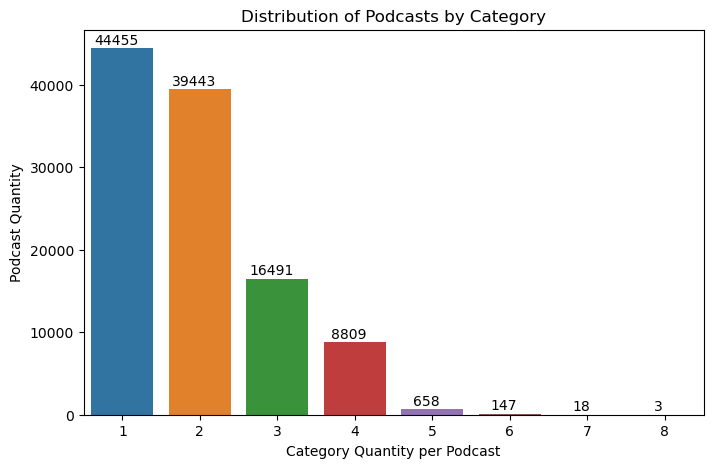

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df_category.podcast_id.value_counts(), data=df_category)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 8),
        textcoords="offset pixels",
    )
plt.xlabel("Category Quantity per Podcast")
plt.ylabel("Podcast Quantity")
plt.title("Distribution of Podcasts by Category")
plt.show()

* Conclusion:
    As we can see from the graph, podcasts may not belong to a single category, which on the one hand broadens the audience, but diminishes the sense of precise classification.  

* Lets add to our tables categories:

In [34]:
df = pd.merge(df_reviews, df_category, on="podcast_id", how="inner")


<IPython.core.display.Javascript object>

In [35]:
df["category"] = df.groupby("title")["category"].transform(lambda x: ", ".join(set(x)))
df.head()

,podcast_id,title,content,rating,author_id,review_date,Year,podcast_type,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24 12:05:16,2018,single,"arts, arts-performing-arts, music"
1,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24 12:05:16,2018,single,"arts, arts-performing-arts, music"
2,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Thanks for providing these insights. Really enjoy the variety and depth -- please keep them coming!,5,F7E5A318989779D,2018-04-24 12:05:16,2018,single,"arts, arts-performing-arts, music"
3,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09 18:14:32,2018,single,"arts, arts-performing-arts, music"
4,c61aa81c9b929a66f0c1db6cbe5d8548,Backstage at Tilles Center,Super excited to see this podcast grow. So many fun topics to talk about...Shari is really engaging. Definitely subscribing and would recommend to anyone interested in the arts!!,5,F6BF5472689BD12,2018-05-09 18:14:32,2018,single,"arts, arts-performing-arts, music"


<IPython.core.display.Javascript object>

* To figure what programmes are most popular (calculating most reviews written), lets get top 5 podcast titles first by review quantity:

In [36]:
title_count = df.groupby(["title"])["rating"].count().sort_values(ascending=False)
title_avg_rating = df.groupby(["title"])["rating"].mean()
top_titles = pd.merge(title_count, title_avg_rating, on="title")
top_titles = top_titles.rename(
    columns={"rating_x": "review_quantity", "rating_y": "average_rating"}
)
top_titles = top_titles.reset_index()
top_titles["average_rating"] = round(top_titles["average_rating"], 2)
category_dict = df.groupby("title")["category"].apply(set).to_dict()
top_titles["category"] = top_titles["title"].map(category_dict)
top_titles.head(5)

,title,review_quantity,average_rating,category
0,Crime Junkie,33104,4.27,{true-crime}
1,Wow in the World,27714,4.77,"{kids-family-stories-for-kids, education, kids-family}"
2,My Favorite Murder with Karen Kilgariff and Georgia Hardstark,21350,3.61,"{comedy, true-crime}"
3,Know Your Aura with Mystic Michaela,20236,4.98,"{education-self-improvement, education, spirituality, religion-spirituality}"
4,Don't Keep Your Day Job,19728,4.94,"{education-self-improvement, religion-spirituality, business, education, business-entrepreneurship, spirituality}"


<IPython.core.display.Javascript object>

In [37]:
top_categories_count = defaultdict(int)
for title in top_titles.head(5)["title"]:
    categories = category_dict[title]
    for category in categories:
        subcategories = category.split(",")
        for subcategory in subcategories:
            top_categories_count[subcategory.strip()] += 1
top_categories_count = sorted(
    top_categories_count.items(), key=lambda x: x[1], reverse=True
)
top_categories_count

[('education', 3),
 ('true-crime', 2),
 ('education-self-improvement', 2),
 ('spirituality', 2),
 ('religion-spirituality', 2),
 ('kids-family-stories-for-kids', 1),
 ('kids-family', 1),
 ('comedy', 1),
 ('business', 1),
 ('business-entrepreneurship', 1)]

<IPython.core.display.Javascript object>

* Conclusion:<br>
To conclude what categories are most popular based on top 5 podcasts with most reviews we can conclude that education category is most popular, followed by true-crime, spirituality. 

## Conclusions:

The main objective of this work is to show what characteristics a popular podcast should have. The period of our study is 2005-2023, the total information provided is 110024 names of the shows, for which 2043297 reviews were given. The annual distribution of the feedback shows that the highest listener activity was in the years 2019-2022. This activity coincides with the period of the COVID-19 pandemic, which may have had an impact on the popularity of this type of entertainment. The impact of crises has not been studied, but such a study would be interesting in the future.
* The number of reviews a podcast would have to have in order to be considered popular should be examined. Most of the podcasts have 1-2 reviews, which hardly defines popularity. The chosen method of calculation shows that having 317 or more reviews would guarantee the popularity of the podcast in terms of viewer response. This number of reviews is available for 1% of all available programmes.
* An attempt to divide the podcasts into single episode and serial episode groups, based on the available data, reveals that single episode programmes are the most popular. This raises the hypothesis whether there is a difference between the ratings of series and one-episode podcasts, and whether this average of the ratings is statistically significant. The t-test used, with 95% confidence, shows that this difference is statistically significant and reveals the advantage of single programmes over series programmes. 
* When comparing the distribution of reviews, it is observed that the vast majority of podcasts have the highest rating, following lowest rating. This raises the hypothesis whether there is a statistically significant difference in the length of reviews between these rating groups. The calculation shows with 95% confidence, that the difference is statistically significant and that the length of the review in the worst-rated podcasts is higher than in the best-rated podcasts. This could be explained by the listener trying to justify in detail his bad rating, which could also be useful for the evaluation of the show: the time spent on such a description is also valuable.
* Finally, the most popular podcasts with the highest response rates are in educational, religious-spiritual and crime theme categories.